# Captum

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../../..')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import datetime

import numpy as np

from src.data import train_test_split, MRISequence
from src.model import create_model, compile_model, load_checkpoint
from src.model.evaluation import show_metrics

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['image.cmap'] = 'viridis'

%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

## Setup

In [4]:
%%time

ROOT_DIR = '../../../../tmp'
DEFAULT_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'checkpoints')
DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'bckp-checkpoints')

LOG_DIRECTORY = os.path.join(ROOT_DIR, 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_CHECKPOINT_DIRECTORY_LOCAL

LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

DATA_DIR_NAME = 'data-v3'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR_NAME)

saliencies_and_segmentations_v2_path = os.path.join(ROOT_DIR, 'saliencies_and_segmentations_v2')

if not os.path.exists(CHECKPOINT_DIRECTORY):
    os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
    os.mkdir(LOG_DIRECTORY)

val = False

class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(
    saliencies_and_segmentations_v2_path,
    ROOT_DIR,
    split=(0.8, 0.15, 0.05),
    dirname=DATA_DIR_NAME)

# set the batch size for mri seq
batch_size = 12
input_shape = (104, 128, 104, 1) # (112, 112, 105, 1)
resize_img = True
crop_img = True

# if y is one-hot encoded or just scalar number
one_hot = True

# class weightss (see analysis notebook)
class_weights = {0: 0.8072289156626505, 1: 1.3137254901960784}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
    print('initializing desc...')
    desc = get_description(MRISequence(
        train_dir,
        64,
        class_names=class_names,
        input_shape=input_shape),
        max_samples=None)
    print(desc)


normalization={ 'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations = None
augmentations_inplace = True
# enable augmentations in mri seq (otherwise it can be enabled in dataset)
# augmentations={ 'random_swap_hemispheres': 0.5 }

# initialize sequences
print('initializing train_seq...')
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=augmentations_inplace,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    class_weights=class_weights,
    normalization=normalization)

print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    normalization=normalization)

if val:
    print('initializing val_seq...')
    val_seq = MRISequence(
        val_dir,
        batch_size,
        class_names=class_names,
        input_shape=input_shape,
        resize_img=resize_img,
        crop_img=crop_img,
        one_hot=one_hot,
        class_weights=class_weights,
        normalization=normalization)
else:
    print('val_seq = test_seq')
    val_seq = test_seq

model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing test_seq...
val_seq = test_seq
log_dir: ../../../../tmp\logs\20210409-110436
Wall time: 31.6 ms


## Model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def log(n, x):
    print(f"\n\n\n---LOG{n}---")
    print(np.transpose(x.detach().cpu().numpy(), axes=(0, 2, 3, 4, 1)))
    x.cuda()

    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm3d(32, affine=True, eps=0.001, momentum=0.99)
        self.mpool1 = nn.MaxPool3d(2, stride=2, padding=0)
        
        self.conv2 = nn.Conv3d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm3d(64, affine=True, eps=0.001, momentum=0.99)
        self.mpool2 = nn.MaxPool3d(3, stride=3)
        
        self.conv3 = nn.Conv3d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm3d(128, affine=True, eps=0.001, momentum=0.99)
        self.mpool3 = nn.MaxPool3d(4, stride=4)
        
        self.flt = nn.Flatten()
        self.dp1 = nn.Dropout(p=0.1)
        
        self.fc1 = nn.Linear(10240, 256)
        self.dp2 = nn.Dropout(p=0.1)
        
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
#         log(1, x)
        x = self.conv1(x)
#         log(2, x)
        x = self.bn1(x)
#         log(3, x)
        x = F.relu(x)
#         log(4, x)
        x = self.mpool1(x)
        torch.cuda.empty_cache()
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.mpool2(x)
        torch.cuda.empty_cache()
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.mpool3(x)      
        
        x = torch.transpose(x, 1, 4) # n, 4, 4, 5, 128 
        x = torch.transpose(x, 2, 3) # n, 4, 5, 4, 128 
        x = torch.transpose(x, 1, 3) # n, 4, 5, 4, 128
        
        x = self.flt(x)
        x = self.dp1(x)
        
        x = F.relu(self.fc1(x))
        torch.cuda.empty_cache()
        x = self.dp2(x)
        
        x = F.softmax(self.fc2(x), dim=1)
        
        return x


net = Net().eval()

In [7]:
weights = np.load(os.path.join(ROOT_DIR, 'tf-weights.npy'), allow_pickle=True)
weights_bn = np.load(os.path.join(ROOT_DIR, 'tf-weights-bn.npy'), allow_pickle=True)

print(list(net.children()))

print("copy trainable parameters...\n")

for (name, param), (tf_name, tf_param) in zip(net.named_parameters(), weights):
    if 'conv' in tf_name and 'kernel' in tf_name:
        tf_param = np.transpose(tf_param, axes=(4, 3, 0, 1, 2))
    else:
        tf_param = tf_param.transpose()
#     if 'fs' in name: # and 'weight' in name:
#         tf_param = tf_param.transpose()
    print(f"\n--- {name} / {tf_name} ---")
    print(tf_param.shape) # .astype(np.float64)
    print(param.shape)
    param.data = torch.from_numpy(tf_param)

print("\n\ncopy batch norm parameters...\n")

i = 0

for child in net.children():
    if isinstance(child, torch.nn.BatchNorm3d):
        var = weights_bn[i + 1]
        mean = weights_bn[i]
        print(f'{var.shape} ({len(var)}) {mean.shape} ({len(mean)})')
        child.running_var = torch.from_numpy(var)
        child.running_mean = torch.from_numpy(mean)
        i += 2
    
net.to('cuda')

[Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)), BatchNorm3d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True), MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)), BatchNorm3d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True), MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False), Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)), BatchNorm3d(128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True), MaxPool3d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False), Flatten(start_dim=1, end_dim=-1), Dropout(p=0.1, inplace=False), Linear(in_features=10240, out_features=256, bias=True), Dropout(p=0.1, inplace=False), Linear(in_features=256, out_features=2, bias=True)]
copy trainable parameters...


--- conv1.weight / conv3d/kernel:0 ---
(32, 1, 3, 3, 3)
torch

Net(
  (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn1): BatchNorm3d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
  (mpool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn2): BatchNorm3d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
  (mpool2): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn3): BatchNorm3d(128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
  (mpool3): MaxPool3d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (flt): Flatten(start_dim=1, end_dim=-1)
  (dp1): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=10240, out_features=256, bias=True)
  (dp2): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_fe

In [8]:
from torchsummary import summary

summary(net.cuda(), (1, 104, 128, 104))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1    [-1, 32, 104, 128, 104]             896
       BatchNorm3d-2    [-1, 32, 104, 128, 104]              64
         MaxPool3d-3       [-1, 32, 52, 64, 52]               0
            Conv3d-4       [-1, 64, 52, 64, 52]          55,360
       BatchNorm3d-5       [-1, 64, 52, 64, 52]             128
         MaxPool3d-6       [-1, 64, 17, 21, 17]               0
            Conv3d-7      [-1, 128, 17, 21, 17]         221,312
       BatchNorm3d-8      [-1, 128, 17, 21, 17]             256
         MaxPool3d-9         [-1, 128, 4, 5, 4]               0
          Flatten-10                [-1, 10240]               0
          Dropout-11                [-1, 10240]               0
           Linear-12                  [-1, 256]       2,621,696
          Dropout-13                  [-1, 256]               0
           Linear-14                   

In [43]:
from src.data import select_from_dataset, tf_predict, torch_predict

images_x, images_y, images_y_pred = select_from_dataset(torch_predict(net), test_seq, max_category=10)

print(images_x.shape)

(40, 104, 128, 104, 1)


In [36]:
from captum.attr import GuidedBackprop, GuidedGradCam, LayerGradCam

# https://captum.ai/api/guided_backprop.html
# https://captum.ai/api/saliency.html
# https://captum.ai/api/guided_grad_cam.html

In [44]:
test_x = np.transpose(images_x, axes=(0, 4, 1, 2, 3))
test_y = images_y
test_y_pred = images_y_pred

test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_x).float(), torch.from_numpy(test_y).float())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

In [46]:
guided_gc = GuidedGradCam(net, net.conv3)

attributions = []

with torch.no_grad():
    for x, y, y_pred in zip(test_x, test_y, test_y_pred):
        target = np.argmax(y, axis=0)
        print(f"target:{target};pred:{y_pred}")
        batch_x = torch.from_numpy(np.array([x])).float().requires_grad_(True).cuda()
        attribution = guided_gc.attribute(batch_x, int(target))
        attributions.append(attribution.to('cpu').detach().numpy()[0])
        
attributions = np.transpose(np.array(attributions), axes=(0, 2, 3, 4, 1))

target:0;pred:0
target:1;pred:1
target:0;pred:0
target:0;pred:0
target:1;pred:1
target:0;pred:0
target:1;pred:1
target:1;pred:0
target:1;pred:0
target:0;pred:0
target:0;pred:0
target:0;pred:0
target:1;pred:1
target:0;pred:0
target:1;pred:1
target:0;pred:0
target:1;pred:1
target:1;pred:1
target:0;pred:0
target:1;pred:0
target:1;pred:1
target:1;pred:1
target:1;pred:0
target:1;pred:1
target:1;pred:0
target:0;pred:1
target:0;pred:1
target:0;pred:1
target:0;pred:1
target:0;pred:1
target:0;pred:1
target:0;pred:1
target:0;pred:1
target:0;pred:1
target:1;pred:0
target:0;pred:1
target:1;pred:0
target:1;pred:0
target:1;pred:0
target:1;pred:0


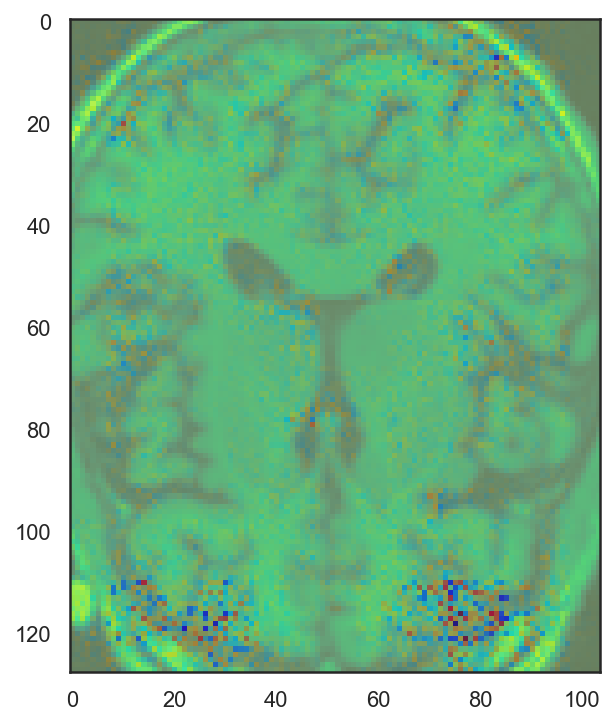

In [55]:
from captum.attr import visualization as viz

# viz.visualize_image_attr(attributions[1][56])
idx = 0
z = 56
plt.imshow(images_x[idx][z])
plt.imshow(attributions[idx][z], cmap='jet', alpha=0.5)

In [67]:
gbp = GuidedBackprop(net)

attributions = []

with torch.no_grad():
    for x, y in zip(test_x, test_y):
        target = np.argmax(y, axis=0)
        batch_x = torch.from_numpy(np.array([x])).float().requires_grad_(True).cuda()
        attribution = gbp.attribute(batch_x, int(target))
        attributions.append(attribution.to('cpu').detach().numpy()[0])
        
attributions = np.transpose(np.array(attributions), axes=(0, 2, 3, 4, 1))

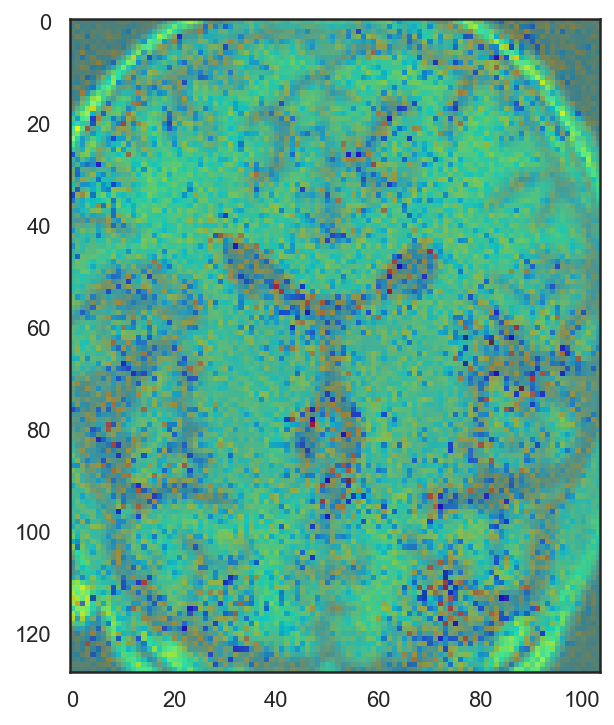

In [69]:
from captum.attr import visualization as viz

# viz.visualize_image_attr(attributions[1][56])
idx = 0
z = 56
plt.imshow(images_x[idx][z])
plt.imshow(attributions[idx][z], cmap='jet', alpha=0.5)

In [57]:
guided_gc = LayerGradCam(net, net.conv3)

attributions = []

with torch.no_grad():
    for x, y in zip(test_x, test_y):
        target = np.argmax(y, axis=0)
        batch_x = torch.from_numpy(np.array([x])).float().requires_grad_(True).cuda()
        attribution = guided_gc.attribute(batch_x, int(target))
        attributions.append(attribution.to('cpu').detach().numpy()[0])
        
attributions = np.transpose(np.array(attributions), axes=(0, 2, 3, 4, 1))

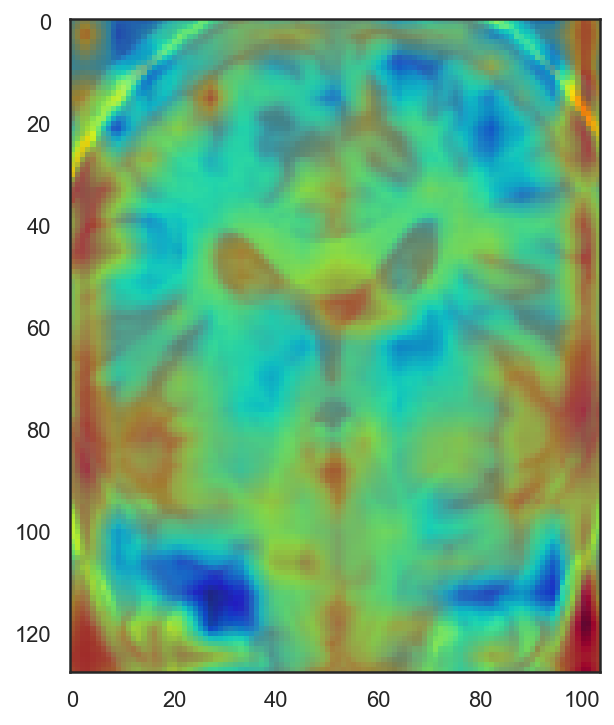

In [66]:
from captum.attr import visualization as viz
from skimage.transform import resize

# viz.visualize_image_attr(attributions[1][56])
idx = 1
z = 56
plt.imshow(images_x[idx][z])
plt.imshow(resize(attributions[idx], input_shape[:-1])[z], cmap='jet', alpha=0.5)